In [4]:
# 导入常用库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# 设置sns样式
# 样式控制：axes_style() and set_style()
# 有5个seaborn的主题，适用于不同的应用和人群偏好：
# darkgrid 黑色网格（默认）
# whitegrid 白色网格
# dark 黑色背景
# white 白色背景
# ticks 应该是四周都有刻度线的白背景
sns.set(style='white',context='notebook',palette='muted')

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [5]:
# 读取完成清理及特征工程的数据
# 数据1：编码格式/code
# 数据2：one-hot格式/dummy
data_1 = pd.read_excel(r'../data/titanic/data_factorized.xlsx', index_col=0)
data_2 = pd.read_excel(r'../data/titanic/data_dummy.xlsx',index_col=0)
data = data_2.copy()

In [6]:
train_x = data[data['Survived'].notnull()].drop(['PassengerId','Survived'], axis=1)
train_y = data[data['Survived'].notnull()][['Survived']]
test_x = data[data['Survived'].isnull()].drop(['PassengerId','Survived'], axis=1)
test_y = data[data['Survived'].isnull()][['PassengerId','Survived']]
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           891 non-null    float64
 1   SibSp         891 non-null    int64  
 2   Parch         891 non-null    int64  
 3   Fare          891 non-null    float64
 4   FamilyBin     891 non-null    int64  
 5   IsAlone       891 non-null    int64  
 6   Sex_female    891 non-null    int64  
 7   Sex_male      891 non-null    int64  
 8   Cabin_A       891 non-null    int64  
 9   Cabin_B       891 non-null    int64  
 10  Cabin_C       891 non-null    int64  
 11  Cabin_D       891 non-null    int64  
 12  Cabin_E       891 non-null    int64  
 13  Cabin_F       891 non-null    int64  
 14  Cabin_G       891 non-null    int64  
 15  Cabin_T       891 non-null    int64  
 16  Cabin_U       891 non-null    int64  
 17  Embarked_C    891 non-null    int64  
 18  Embarked_Q    891 non-null    

In [7]:
# 算法初选,构建一堆分类器
# 设置默认参数，对所有模型进行对比测试，基于训练/测试预测精度，初选回归模型
# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # Ensemble Methods
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Navies Bayes
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors
    neighbors.KNeighborsClassifier(),
    
    # SVM
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # neural_network
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network
    neural_network.MLPClassifier(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [8]:
# 数据拆分为训练集和测试集，拆分10次，每次25%用于测试，75%用于训练
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0)
# 模型对比结果矩阵，存储测试结果，包含算法名称、算法参数、训练准确率、测试准确率、测试准确率标准差、耗时
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
# 预测结果矩阵，存储真实值与预测值
MLA_predict = train_y.copy()

In [9]:
# index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name   # 算法名称
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())    # 算法参数
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html?highlight=cross_validate
    cv_results = model_selection.cross_validate(alg, train_x, train_y, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(train_x, train_y)
    MLA_predict[MLA_name] = alg.predict(train_x)
    row_index+=1
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.838523,0.834328,0.0436997,0.0948025
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.847833,0.832463,0.0526119,0.0840141
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.840289,0.829851,0.0451107,0.0103913
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.857945,0.828731,0.0494188,0.00669301
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.913483,0.827239,0.0684668,0.134761
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.900321,0.827239,0.0682836,0.237649
21,MLPClassifier,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.88427,0.824627,0.0648868,0.825255
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.839005,0.824627,0.0566378,0.00719233
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.838202,0.823881,0.0505098,0.728654
22,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.980899,0.820149,0.0735406,0.0866113


Text(0, 0.5, 'Algorithm')

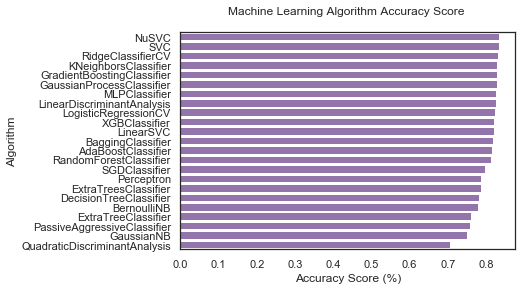

In [11]:
# 可视化各分类器
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [12]:
# 模型参数优化对精度影响： 优化前平均预测精度77.76
# base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, train_x, train_y, cv  = cv_split, return_train_score=True)
dtree.fit(train_x, train_y)
print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 98.94
BEFORE DT Test w/bin score mean: 77.76
BEFORE DT Test w/bin score 3*std: +/- 7.10
----------


In [13]:
# 超参数优化，对比优化前预测精度：参数优化后，精度由77.76提高至87.26
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }
#choose best model parameter with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train_x, train_y)

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

AFTER DT Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 0.03, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'}
AFTER DT Training w/bin score mean: 91.16
AFTER DT Test w/bin score mean: 87.26
AFTER DT Test w/bin score 3*std: +/- 6.34
----------


In [14]:
# 特征参数选择，过多特征值不一定有助于分类器工作：缩减特征值，精度提高了1%，对结果偏差的影响更大
# base model
print('BEFORE DT RFE Training Shape Old: ', train_x.shape) 
# print('BEFORE DT RFE Training Columns Old: ', train_x.columns.values)
print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

# feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(train_x, train_y)

# transform x&y to reduced features and fit new model
# alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = train_x.columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree,train_x[X_rfe], train_y, cv=cv_split, return_train_score=True)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', train_x[X_rfe].shape) 
# print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 35)
BEFORE DT RFE Training w/bin score mean: 98.94
BEFORE DT RFE Test w/bin score mean: 77.76
BEFORE DT RFE Test w/bin score 3*std: +/- 7.10
----------
AFTER DT RFE Training Shape New:  (891, 13)
AFTER DT RFE Training w/bin score mean: 98.94
AFTER DT RFE Test w/bin score mean: 78.47
AFTER DT RFE Test w/bin score 3*std: +/- 5.08
----------


In [15]:
# 超参数优化，精度由80.18%提高到86.5%，相对于全特征模型，精度几乎一致
# tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
rfe_tune_model.fit(train_x[X_rfe], train_y)

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

AFTER DT RFE Tuned Parameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 0.03, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'}
AFTER DT RFE Tuned Training w/bin score mean: 91.08
AFTER DT RFE Tuned Test w/bin score mean: 87.54
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.56
----------


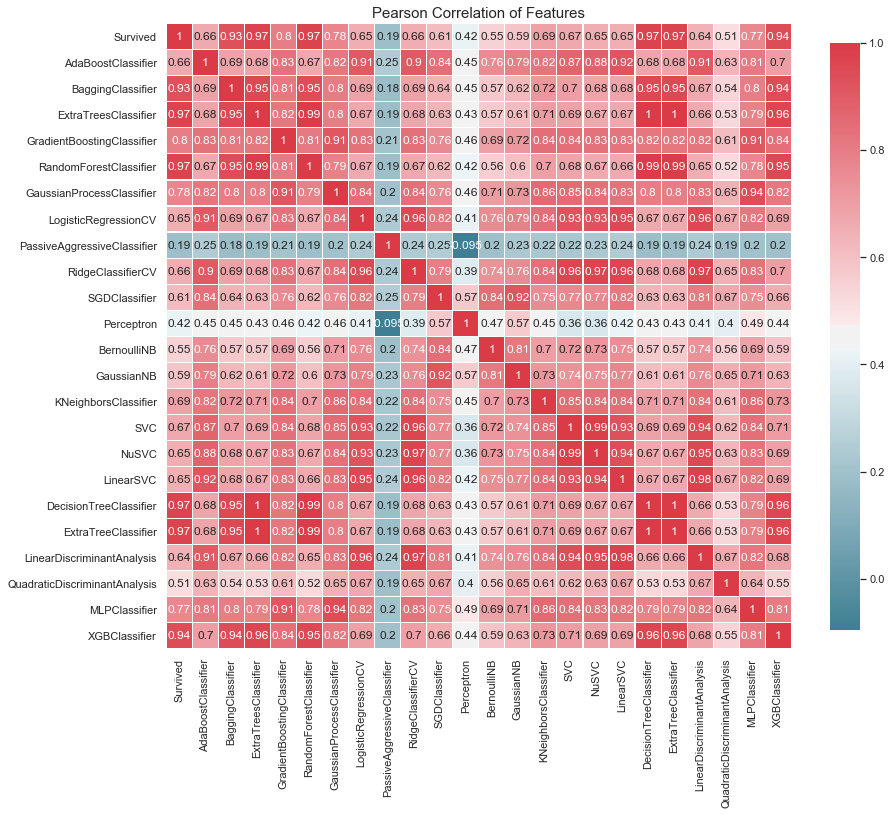

In [16]:
# correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
# 各模型相关性分析
correlation_heatmap(MLA_predict)
# ETC = DTC = ETC'
# RCCV = LDA

In [17]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),

    # neural_network
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network
    # ('mlpc', neural_network.MLPClassifier()),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]

In [22]:
# 模型融合，hard模式
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_x[X_rfe], train_y, cv  = cv_split, return_train_score=True)
vote_hard.fit(train_x[X_rfe], train_y)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 90.06
Hard Voting Test w/bin score mean: 83.25
Hard Voting Test w/bin score 3*std: +/- 5.31
----------


In [23]:
# Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_x[X_rfe], train_y, cv = cv_split, return_train_score=True)
vote_soft.fit(train_x[X_rfe], train_y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting Training w/bin score mean: 91.59
Soft Voting Test w/bin score mean: 83.47
Soft Voting Test w/bin score 3*std: +/- 6.94
----------


In [24]:
# 超参数优化，设置各分类器优化空间
# Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

          #   [{
          #   #neural net - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
          #   #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
          #   #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          #   'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)], #default=1.0
          #   'activation': ['identity','logistic','tanh', 'relu'], #edfault: auto
          #   'solver': ['lbfgs', 'sgd', 'adam'], #default:ovr
          #   'alpha': [0.1, 0.01, 0.001, 0.0001],
          #   'learning_rate':['constant', 'invscaling', 'adaptive']
          #    }],
    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]


In [25]:
import time
start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(train_x[X_rfe], train_y)
    print('The mean test score of model {}: {}'.format(clf[1].__class__.__name__, best_search.cv_results_['mean_test_score'].mean()*100))
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    # print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))
print('-'*10)

The mean test score of model AdaBoostClassifier: 84.23118286084792
The mean test score of model BaggingClassifier: 87.65912465244382
The mean test score of model ExtraTreesClassifier: 85.83376965193737
The mean test score of model GradientBoostingClassifier: 86.63422804763955
The mean test score of model RandomForestClassifier: 87.01951883564644
The mean test score of model GaussianProcessClassifier: 86.25261583705843
The mean test score of model LogisticRegressionCV: 87.29241433657833
The mean test score of model BernoulliNB: 84.76411449943913
The mean test score of model GaussianNB: 82.94360711060608
The mean test score of model KNeighborsClassifier: 83.7351931770682
The mean test score of model SVC: 84.67602003316041
The mean test score of model XGBClassifier: 86.7671823882745
Total optimization time was 8.46 minutes.
----------


In [26]:
# 模型融合，hard模式
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_x[X_rfe], train_y, cv  = cv_split, return_train_score=True)
vote_hard.fit(train_x[X_rfe], train_y)
print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 87.58
Hard Voting Test w/bin score mean: 82.87
Hard Voting Test w/bin score 3*std: +/- 5.61
----------


In [28]:
# 模型融合，soft模式
#Hard Vote or majority rules
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_x[X_rfe], train_y, cv  = cv_split, return_train_score=True)
vote_soft.fit(train_x[X_rfe], train_y)
print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting Training w/bin score mean: 86.60
Soft Voting Test w/bin score mean: 82.43
Soft Voting Test w/bin score 3*std: +/- 5.49
----------


In [30]:
# 对所有分类器进行预测分析，保存对应结果
for clf in vote_est:
    #TitanicGBSmodle
    clf[1].fit(train_x[X_rfe], train_y)
    print('Training score for %s: %.4f' %(clf[0], clf[1].score(train_x[X_rfe], train_y)))
    preData_y=clf[1].predict(test_x[X_rfe])
    preData_y=preData_y.astype(int)
    #导出预测结果
    preResultDf=test_y.copy()
    preResultDf['Survived']=preData_y
    #将预测结果导出为csv文件
    preResultDf.to_csv(r'../data/titanic/result_%s.csv' %clf[0], index=False)

# 模型融合，hard模式
#Hard Vote or majority rules
print('Training score for Hard Tune: %.4f' %vote_hard.score(train_x[X_rfe], train_y))
preData_y=vote_hard.predict(test_x[X_rfe])
preData_y=preData_y.astype(int)
#导出预测结果
preResultDf=test_y.copy()
preResultDf['Survived']=preData_y
#将预测结果导出为csv文件
preResultDf.to_csv(r'../data/titanic/titanic_hard_tune.csv', index=False)

# 模型融合，soft模式
#Hard Vote or majority rules
print('Training score for Soft Tune: %.4f' %vote_soft.score(train_x[X_rfe], train_y))
preData_y=vote_soft.predict(test_x[X_rfe])
preData_y=preData_y.astype(int)
#导出预测结果
preResultDf=test_y.copy()
preResultDf['Survived']=preData_y
#将预测结果导出为csv文件
preResultDf.to_csv(r'../data/titanic/result_soft_tune.csv', index=False)

Training score for ada: 0.8496
Training score for bc: 0.8956
Training score for etc: 0.8844
Training score for gbc: 0.8698
Training score for rfc: 0.9136
Training score for gpc: 0.8664
Training score for lr: 0.8339
Training score for bnb: 0.7856
Training score for gnb: 0.8013
Training score for knn: 0.8563
Training score for svc: 0.8418
Training score for xgb: 0.8844
Training score for Hard Tune: 0.8698
Training score for Soft Tune: 0.8642
